In [1]:
SAVE = False

Combine relevant evaluation files into a single file

In [2]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
combined_eval_file = []

for mrt in MRT:

    results_dirs = [
        f'v3_MRT{mrt}_SimpleModels_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Kalman_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Transformer_every_day/00_summary_7stepsahead_interv'
        ] 

    eval_files = []
    for rd in results_dirs:
        eval_files.append(data_utils.join_ordinal_bptt_path('results', rd, 'evaluation.csv'))
        assert os.path.exists(eval_files[-1])
    eval_reallabor_utils.clear_line_and_print(f'Combining evaluation files')
    mrt_combined_eval_file = eval_reallabor_utils.combine_evaluation_files(eval_files, 
                                                                        save_path=None,
                                                                        specifier_name='latent_model')
    mrt_combined_eval_file['MRT'] = mrt

    use_days_from_file = data_utils.train_test_split_path(mrt, 'valid_first_alarms_no_con_smoothed.csv')
    valid_days = pd.read_csv(use_days_from_file, index_col=0)
    valid_days.columns = [int(c) for c in valid_days.columns]

    eval_reallabor_utils.clear_line_and_print(f'Filtering out invalid days')
    eval_only_valid_days = []
    for p, group in mrt_combined_eval_file.groupby('participant'):
        if p in valid_days.columns:
            eval_only_valid_days.append(group.loc[group['test_day'].isin(valid_days[p])])
    mrt_combined_eval_file = pd.concat(eval_only_valid_days, axis=0, ignore_index=True)
    
    mrt_combined_eval_file['prediction'] = mrt_combined_eval_file['prediction'].clip(0, 8)

    combined_eval_file.append(mrt_combined_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)

Creating grand combined evaluation file                                                                                                                                                                 

Calculate all the metrics and their confidence intervals, separately for models and MRT

In [3]:
from eval_reallabor import reallabor_metrics
m_manager = reallabor_metrics.MetricsManager(combined_eval_file, hyperparameters=['latent_model', 'train_on_data_until_timestep', 'valid_training_data_ratio', 'valid_training_data_points', 'MRT'],
                                             only_nonzero_differences=False, include_r2=False)

In [7]:
metrics, errorbars = {}, {}
metrics['mae'] = m_manager.mae(func='mean')
errorbars['mae'] = m_manager.mae(func='sem')
# metrics['diff mae'] = m_manager.diff_mae(func='mean')
# errorbars['diff mae'] = m_manager.diff_mae(func='sem')
# metrics['interv mae'] = m_manager.interv_mae(func='mean')
# errorbars['interv mae'] = m_manager.interv_mae(func='sem')
# metrics[r'interv. effect mae'] = m_manager.interv_diff_mae(func='mean')
# errorbars[r'interv. effect mae'] = m_manager.interv_diff_mae(func='sem')

## Train set length

Plot metrics against train set length, #valid data points and valid ratio

Regression of train set length on metrics:
VAR1                      mae        b = -0.00130, p = 0.000
KalmanFilter              mae        b = -0.00027, p = 0.288
clipped-shallow-PLRNN     mae        b = -0.00039, p = 0.036


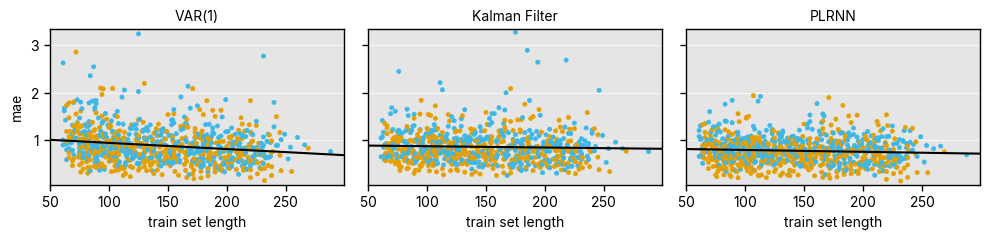

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
from plotting_utils import adjust_ylim, plot_regression

model_labels = {
                    # 'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 
                    'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    # 'Transformer': 'Transformer'
                    }

tl_corr_r = pd.DataFrame(index=model_labels.keys(), columns=metrics.keys(), dtype=float)
tl_corr_p = pd.DataFrame(index=model_labels.keys(), columns=metrics.keys(), dtype=float)
print('Regression of train set length on metrics:')
with PaperStyle():

    for i, m in enumerate(metrics):

        fig, axes = plt.subplots(1, len(model_labels), figsize=(10, 2.5), sharex=False, sharey='row')

        for j, model in enumerate(model_labels.keys()):

            # for mrt in MRT:
            this_line = metrics[m].loc[(model)]
            x = this_line.index.get_level_values('train_on_data_until_timestep')
            y = this_line.values
            c = pd.Series(this_line.index.get_level_values('MRT')).replace({2: colors.color_cycle[0], 3: colors.color_cycle[1]})
            _, regr, corr = plot_regression(x, y, ax=axes[j], scatter_kwargs={'marker':'.', 'color':c}, line_kwargs={'color':'k'}, nan_policy='omit')
            print(f'{model.ljust(25)} {m.ljust(10)} b = {regr.slope:.5f}, p = {regr.pvalue:.3f}')
            tl_corr_r.loc[model, m], tl_corr_p.loc[model, m] = corr.correlation.item(), corr.pvalue.item()
            adjust_ylim(axes[j], 0.01, 0.01)
            axes[j].set(title=model_labels[model])
            axes[j].set(xlabel='train set length')
        axes[0].set(ylabel=m)    
        plt.tight_layout()

        if SAVE:
            plt.savefig(f'../results/_paper/determinants_of_forecasting_quality/explorative_train_len_{m}.svg', dpi=300)
    plt.show()

Plot the running mean MAE over train set length

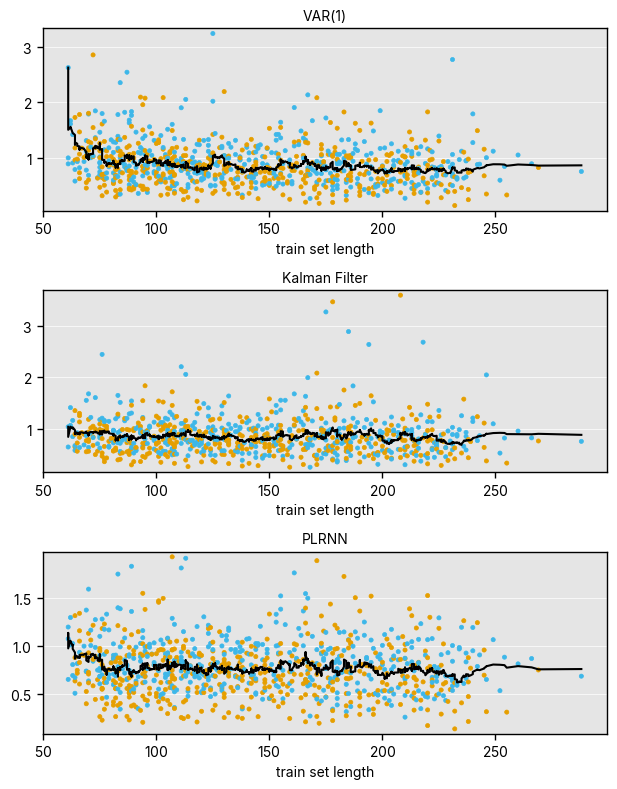

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
from plotting_utils import adjust_ylim, plot_regression

model_labels = {
                    # 'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 
                    'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    # 'Transformer': 'Transformer'
                    }

with PaperStyle():

    fig, axes = plt.subplots(len(model_labels), 1, figsize=(6.27, len(model_labels)*2+2))

    for j, model in enumerate(model_labels.keys()):

        # for mrt in MRT:
        this_line = metrics['mae'].loc[(model)].sort_index(level='train_on_data_until_timestep')
        x = this_line.index.get_level_values('train_on_data_until_timestep')
        y = this_line.rolling(window=25, min_periods=1).mean().values
        s = this_line.values
        c = pd.Series(this_line.index.get_level_values('MRT')).replace({2: colors.color_cycle[0], 3: colors.color_cycle[1]})
        axes[j].scatter(x, s, marker='.', color=c)
        axes[j].plot(x, y, color='k')
        adjust_ylim(axes[j], 0.03, 0.03)
        axes[j].set(title=model_labels[model], xlabel='train set length')
       
    plt.tight_layout()

    if SAVE:
        plt.savefig('../results/_paper/determinants_of_forecasting_quality/explorative_train_len_running_mean.svg', dpi=300)
    plt.show()

Visualize the correlations in heatmaps for each MRT and highlight significant correlations with a star

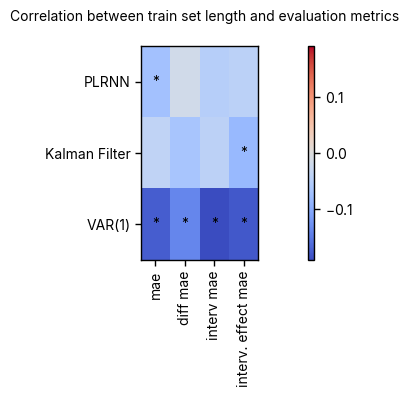

In [10]:
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
from plotting_utils import heatmap_with_colorbar

with PaperStyle(settings={'axes.grid':False}):

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 4))

    heatmap_with_colorbar(ax, tl_corr_r.to_numpy(), cmap='coolwarm', symmetrical=True)
    ax.set(xticks=range(len(metrics)))
    ax.set_xticklabels(metrics.keys(), rotation=90)
    for j, m in enumerate(metrics):
        for k, model in enumerate(model_labels.keys()):
            if tl_corr_p.loc[model, m] < 0.05:
                ax.text(j, k, '*', ha='center', va='center', color='black')
    ax.set_yticks(range(len(model_labels)), labels=model_labels.values())
    fig.suptitle('Correlation between train set length and evaluation metrics')
    plt.tight_layout()
    plt.show()
    

## Valid Ratio

Plot metrics against valid ratio

Regression of valid training data ratio on metrics:
VAR1                      mae        b = -0.40055, p = 0.000
KalmanFilter              mae        b = -0.33475, p = 0.000
clipped-shallow-PLRNN     mae        b = -0.19513, p = 0.000
Transformer               mae        b = -0.22731, p = 0.000


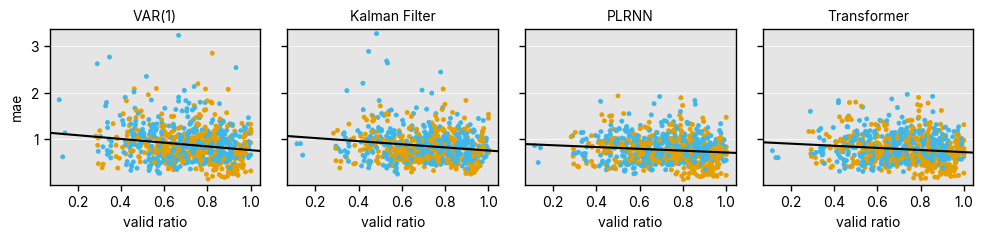

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
from plotting_utils import adjust_ylim, plot_regression

model_labels = {
                    # 'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 
                    'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'Transformer': 'Transformer'
                    }

vr_corr_r = pd.DataFrame(index=model_labels.keys(), columns=metrics.keys(), dtype=float)
vr_corr_p = pd.DataFrame(index=model_labels.keys(), columns=metrics.keys(), dtype=float)
print('Regression of valid training data ratio on metrics:')
with PaperStyle():

    for i, m in enumerate(metrics):

        fig, axes = plt.subplots(1, len(model_labels), figsize=(10, 2.5), sharex=False, sharey='row')

        for j, model in enumerate(model_labels.keys()):

            # for mrt in MRT:
            this_line = metrics[m].loc[(model)]
            x = this_line.index.get_level_values('valid_training_data_ratio')
            y = this_line.values
            c = pd.Series(this_line.index.get_level_values('MRT')).replace({2: colors.color_cycle[0], 3: colors.color_cycle[1]})
            _, regr, corr = plot_regression(x, y, ax=axes[j], scatter_kwargs={'marker':'.', 'color':c}, line_kwargs={'color':'k'}, nan_policy='omit')
            print(f'{model.ljust(25)} {m.ljust(10)} b = {regr.slope:.5f}, p = {regr.pvalue:.3f}')
            vr_corr_r.loc[model, m], vr_corr_p.loc[model, m] = corr.correlation.item(), corr.pvalue.item()
            adjust_ylim(axes[j], 0.01, 0.01)
            axes[j].set(title=model_labels[model])
            axes[j].set(xlabel='valid ratio')
        axes[0].set(ylabel=m)    
        plt.tight_layout()

        if SAVE:
            plt.savefig(f'../results/_paper/determinants_of_forecasting_quality/explorative_valid_ratio_{m}.svg', dpi=300)
    plt.show()

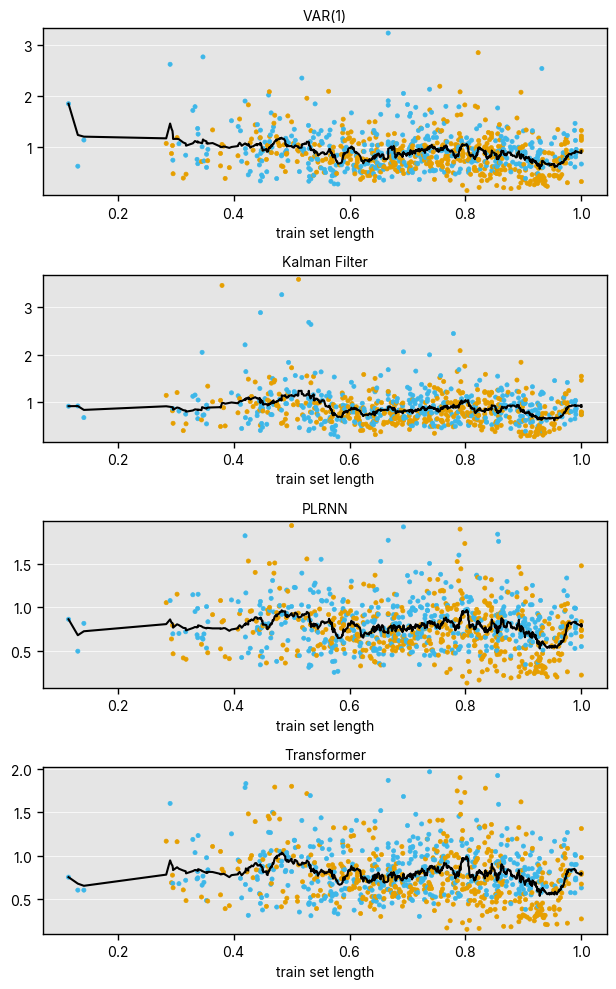

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
from plotting_utils import adjust_ylim, plot_regression

model_labels = {
                    # 'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 
                    'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'Transformer': 'Transformer'
                    }

with PaperStyle():

    fig, axes = plt.subplots(len(model_labels), 1, figsize=(6.27, len(model_labels)*2+2))

    for j, model in enumerate(model_labels.keys()):

        # for mrt in MRT:
        this_line = metrics['mae'].loc[(model)].sort_index(level='valid_training_data_ratio')
        x = this_line.index.get_level_values('valid_training_data_ratio')
        y = this_line.rolling(window=25, min_periods=1).mean().values
        s = this_line.values
        c = pd.Series(this_line.index.get_level_values('MRT')).replace({2: colors.color_cycle[0], 3: colors.color_cycle[1]})
        axes[j].scatter(x, s, marker='.', color=c)
        axes[j].plot(x, y, color='k')
        adjust_ylim(axes[j], 0.03, 0.03)
        axes[j].set(title=model_labels[model], xlabel='train set length')
       
    plt.tight_layout()

    if SAVE:
        plt.savefig('../results/_paper/determinants_of_forecasting_quality/explorative_valid_ratio_running_mean.svg', dpi=300)
    plt.show()

Visualize the correlations in heatmaps and highlight significant correlations with a star

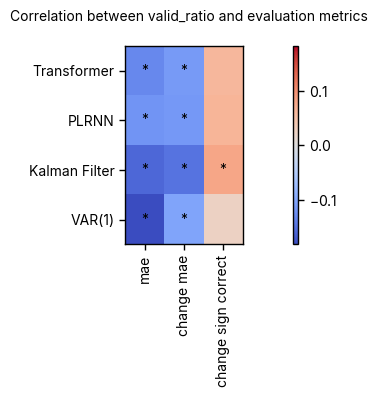

In [23]:
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
from plotting_utils import heatmap_with_colorbar

with PaperStyle(settings={'axes.grid':False}):

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 4))

    heatmap_with_colorbar(ax, vr_corr_r.to_numpy(), cmap='coolwarm', symmetrical=True)
    ax.set(xticks=range(len(metrics)))
    ax.set_xticklabels(metrics.keys(), rotation=90)
    for j, m in enumerate(metrics):
        for k, model in enumerate(model_labels.keys()):
            if vr_corr_p.loc[model, m] < 0.05:
                ax.text(j, k, '*', ha='center', va='center', color='black')
    ax.set_yticks(range(len(model_labels)), labels=model_labels.values())
    fig.suptitle('Correlation between valid_ratio and evaluation metrics')
    plt.tight_layout()
    plt.show()
    

## Valid set length

Plot metrics against #valid data points


VAR1 mae b = -0.00257, p = 0.000
KalmanFilter mae b = -0.00132, p = 0.000
clipped-shallow-PLRNN mae b = -0.00093, p = 0.000
Transformer mae b = -0.00093, p = 0.000
VAR1 diff mae b = -0.00175, p = 0.000
KalmanFilter diff mae b = -0.00124, p = 0.000
clipped-shallow-PLRNN diff mae b = -0.00060, p = 0.058
Transformer diff mae b = -0.00075, p = 0.018
VAR1 interv mae b = -0.00284, p = 0.000
KalmanFilter interv mae b = -0.00112, p = 0.003
clipped-shallow-PLRNN interv mae b = -0.00088, p = 0.003
Transformer interv mae b = -0.00093, p = 0.003
VAR1 interv. effect mae b = -0.00236, p = 0.000
KalmanFilter interv. effect mae b = -0.00164, p = 0.000
clipped-shallow-PLRNN interv. effect mae b = -0.00090, p = 0.009
Transformer interv. effect mae b = -0.00113, p = 0.001


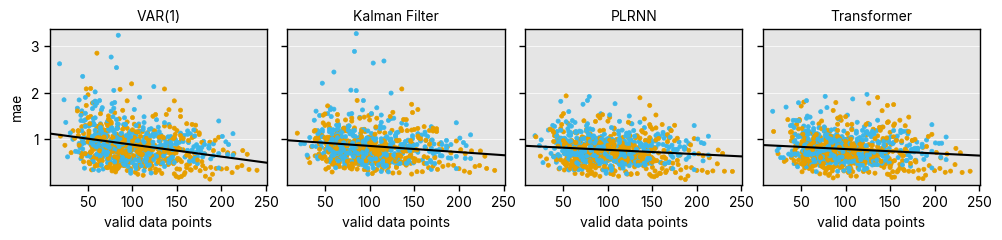

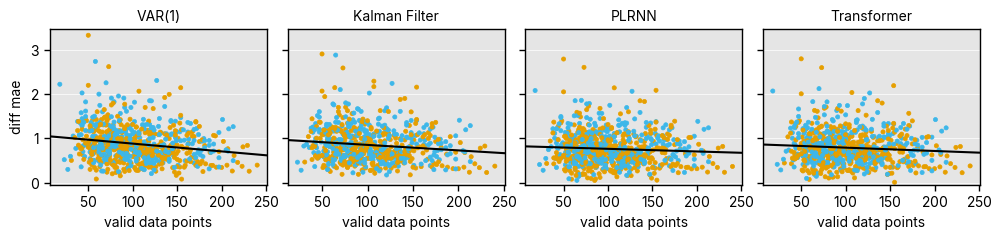

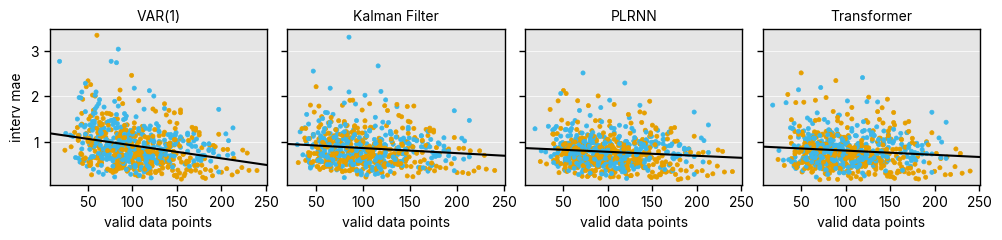

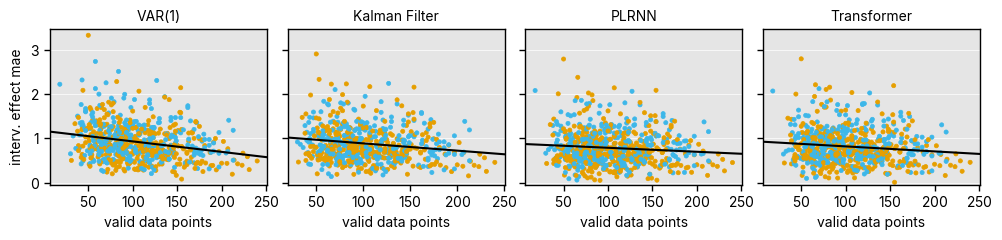

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
from plotting_utils import adjust_ylim, plot_regression

model_labels = {
                    # 'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 
                    'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'Transformer': 'Transformer'
                    }

vp_corr_r = pd.DataFrame(index=model_labels.keys(), columns=metrics.keys(), dtype=float)
vp_corr_p = pd.DataFrame(index=model_labels.keys(), columns=metrics.keys(), dtype=float)
with PaperStyle():
    
    for i, m in enumerate(metrics):

        fig, axes = plt.subplots(1, len(model_labels), figsize=(10, 2.5), sharex=False, sharey='row')

        for j, model in enumerate(model_labels.keys()):

            # for mrt in MRT:
            this_line = metrics[m].loc[(model)]
            x = this_line.index.get_level_values('valid_training_data_points')
            y = this_line.values
            c = pd.Series(this_line.index.get_level_values('MRT')).replace({2: colors.color_cycle[0], 3: colors.color_cycle[1]})
            _, regr, corr = plot_regression(x, y, ax=axes[j], scatter_kwargs={'marker':'.', 'color':c}, line_kwargs={'color':'k'}, nan_policy='omit')
            print(f'{model} {m} b = {regr.slope:.5f}, p = {regr.pvalue:.3f}')
            vp_corr_r.loc[model, m], vp_corr_p.loc[model, m] = corr.correlation.item(), corr.pvalue.item()
            adjust_ylim(axes[j], 0.01, 0.01)
            axes[j].set(title=model_labels[model])
            axes[j].set(xlabel='valid data points')
        axes[0].set(ylabel=m)    
        plt.tight_layout()

        if SAVE:
            plt.savefig(f'../results/_paper/determinants_of_forecasting_quality/explorative_valid_data_points_{m}.svg', dpi=300)
    plt.show()

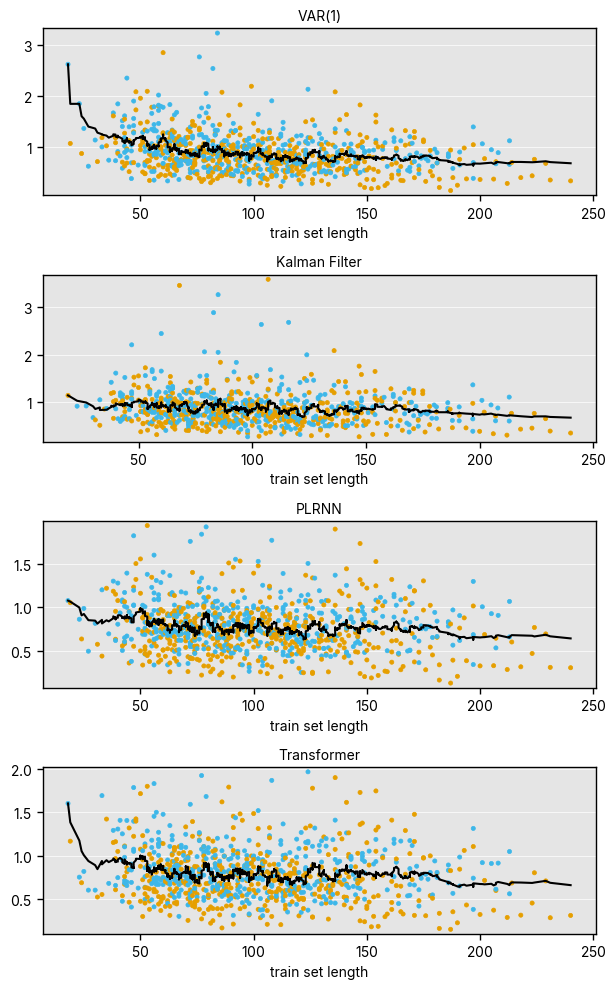

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
from plotting_utils import adjust_ylim, plot_regression

model_labels = {
                    # 'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 
                    'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'Transformer': 'Transformer'
                    }

with PaperStyle():

    fig, axes = plt.subplots(len(model_labels), 1, figsize=(6.27, len(model_labels)*2+2))

    for j, model in enumerate(model_labels.keys()):

        # for mrt in MRT:
        this_line = metrics['mae'].loc[(model)].sort_index(level='valid_training_data_points')
        x = this_line.index.get_level_values('valid_training_data_points')
        y = this_line.rolling(window=25, min_periods=1).mean().values
        s = this_line.values
        c = pd.Series(this_line.index.get_level_values('MRT')).replace({2: colors.color_cycle[0], 3: colors.color_cycle[1]})
        axes[j].scatter(x, s, marker='.', color=c)
        axes[j].plot(x, y, color='k')
        adjust_ylim(axes[j], 0.03, 0.03)
        axes[j].set(title=model_labels[model], xlabel='train set length')
       
    plt.tight_layout()

    if SAVE:
        plt.savefig('../results/_paper/determinants_of_forecasting_quality/explorative_valid_data_points_running_mean.svg', dpi=300)
    plt.show()

Visualize the correlations in heatmaps and highlight significant correlations with a star

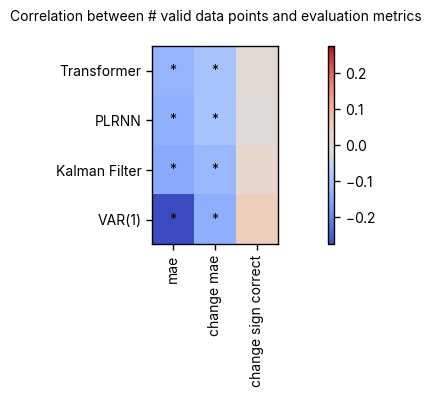

In [26]:
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
from plotting_utils import heatmap_with_colorbar

with PaperStyle(settings={'axes.grid':False}):

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 4))

    heatmap_with_colorbar(ax, vp_corr_r.to_numpy(), cmap='coolwarm', symmetrical=True)
    ax.set(xticks=range(len(metrics)))
    ax.set_xticklabels(metrics.keys(), rotation=90)
    for j, m in enumerate(metrics):
        for k, model in enumerate(model_labels.keys()):
            if vp_corr_p.loc[model, m] < 0.05:
                ax.text(j, k, '*', ha='center', va='center', color='black')
    ax.set_yticks(range(len(model_labels)), labels=model_labels.values())
    fig.suptitle('Correlation between # valid data points and evaluation metrics')
    plt.tight_layout()
    plt.show()
    